In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#한글 나오게
import matplotlib
from matplotlib import font_manager, rc
import platform
if platform.system()=="Windows":
    font_name=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings("ignore")

In [ ]:
path='/content/drive/MyDrive/동서발전 태양광 발전량 예측 AI 경진대회/data/'
#path='/content/drive/MyDrive/Colab Notebooks/전주시 데이터분석/data/'# - 가원, 슬쩍돌려보구 가겠습니당
obs=pd.read_csv(path+'ulsan_obs_data.csv')
site_info=pd.read_csv(path+'site_info.csv')
fcst=pd.read_csv(path+'ulsan_fcst_data.csv')
energy=pd.read_csv(path+'energy.csv')
solar=pd.read_csv(path+'pohang_ilsa.csv')
mise=pd.read_csv(path+'ulsan_mise.csv')
rain=pd.read_csv(path+'ulsan_rain.csv')
submission=pd.read_csv(path+'sample_submission.csv')

# 1. 데이터 확인

- obs=울산지역 발전소 인근 기상 관측 자료
  - 1시간 단위 관측 자료

- fcst=울산지역 발전소 동네 예보
  - 2시, 5시, 8시, 11시, 14시, 17시, 20시, 23시 -> 8번 예보
  - 다음날 24시까지 예보(최소 46시간 후, 최대 67시간 후)
- energy
- solar

In [ ]:
obs.info()
solar.info()
energy.info()
mise.info()
rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25632 entries, 0 to 25631
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   지점         25632 non-null  int64  
 1   지점명        25632 non-null  object 
 2   일시         25632 non-null  object 
 3   기온(°C)     25628 non-null  float64
 4   풍속(m/s)    25631 non-null  float64
 5   풍향(16방위)   25631 non-null  float64
 6   습도(%)      25631 non-null  float64
 7   전운량(10분위)  24807 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   지점         26304 non-null  int64  
 1   지점명        26304 non-null  object 
 2   일시         26304 non-null  object 
 3   일조(hr)     14402 non-null  float64
 4   일조 QC플래그   15100 non-null  float64
 5   일사(MJ/m2)  14402 non-null  float64
dt

### 결측치 위치

In [ ]:
print(obs[obs['temp'].isnull()]) #21820, 21836, 21837, 21840
print(obs[obs['windSpeed'].isnull()]) #11242
print(obs[obs['humidity'].isnull()]) #15395
print(obs[obs['cloud'].isnull()]) #채워야 할 결측치 825개

In [ ]:
def preprocess(obs,solar,energy): 

  #관측자료 전처리
  obs_columns={'지점':'facility_code',
              '지점명':'facility_name',
              '일시':'time',
              '기온(°C)':'temp',
              '풍속(m/s)':'windSpeed',
              '풍향(16방위)':'windDirection',
              '습도(%)':'humidity',
              '전운량(10분위)':'cloud'
  }

  obs.rename(columns=obs_columns, inplace=True)
  obs['time']=pd.to_datetime(obs['time'])
  obs=obs.iloc[:,2:]
  
  #일사량 전처리
  solar.rename(columns={'일시':'time',
                      '일조(hr)':'sun_hr',
                      '일조 QC플래그':'sun_qc',
                      '일사(MJ/m2)':'solar'    
  }, inplace=True)
  solar=solar[['time','sun_hr','solar']]
  solar['time']=pd.to_datetime(solar['time'])
  solar=solar.fillna(0)

  data=pd.merge(obs, solar, how='inner', on='time')

  #해당 열들 더미화 다르게 해보기
  data['year']=data['time'].dt.year
  data['month']=data['time'].dt.month
  data['day']=data['time'].dt.day
  data['hour']=data['time'].dt.hour
  data['season']=data['time'].dt.month %12 //3 +1
  #겨울:1 봄:2 여름:3 가을:4

  #에너지 전처리
  #발전량 시간 1시 ->  0시로 바꾸기
  def convert_time(x):
      date, hr = x.split(' ')
      h,m,s = hr.split(':')
      h = str(int(h)-1)
      hr = ':'.join([h,m,s])
      return ' '.join([date, hr])

  energy['time']=energy['time'].apply(convert_time)
  energy['time']=pd.to_datetime(energy['time'])
  energy=energy.rename(columns={'ulsan':'y'})
  
  ulsan=energy[['y']]
  ulsan=pd.concat([data,ulsan], axis=1)
  ulsan.set_index('time',inplace=True)

  #기온 4개, 풍속, 풍향, 습도 1개씩 결측값 2차 polynomial 보간
  ulsan['temp'].interpolate(method='polynomial', order=2,inplace=True) 
  ulsan['windSpeed'].interpolate(method='polynomial', order=2,inplace=True) 
  ulsan['windDirection'].interpolate(method='polynomial', order=2,inplace=True) 
  ulsan['humidity'].interpolate(method='polynomial', order=2,inplace=True) 

  return ulsan

In [ ]:
ulsan=preprocess(obs,solar,energy)
ulsan

,temp,windSpeed,windDirection,humidity,cloud,sun_hr,solar,year,month,day,hour,season,y
time,,,,,,,,,,,,,
2018-03-01 00:00:00,8.2,3.9,340.0,98.0,10.0,0.0,0.0,2018,3,1,0,2,0
2018-03-01 01:00:00,7.0,4.1,320.0,97.0,10.0,0.0,0.0,2018,3,1,1,2,0
2018-03-01 02:00:00,6.5,5.9,290.0,80.0,NaN,0.0,0.0,2018,3,1,2,2,0
2018-03-01 03:00:00,6.2,4.6,320.0,79.0,3.0,0.0,0.0,2018,3,1,3,2,0
2018-03-01 04:00:00,6.7,4.5,320.0,73.0,1.0,0.0,0.0,2018,3,1,4,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31 19:00:00,8.8,2.5,200.0,50.0,5.0,0.0,0.0,2021,1,31,19,1,0
2021-01-31 20:00:00,8.7,3.9,200.0,49.0,1.0,0.0,0.0,2021,1,31,20,1,0
2021-01-31 21:00:00,8.4,2.4,230.0,51.0,7.0,0.0,0.0,2021,1,31,21,1,0


In [ ]:
ulsan.isnull().sum()

temp               0
windSpeed          0
windDirection      0
humidity           0
cloud            825
sun_hr             0
solar              0
year               0
month              0
day                0
hour               0
season             0
y                  0
dtype: int64

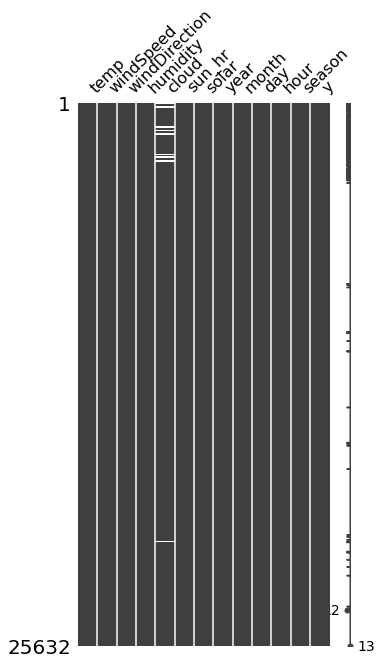

In [ ]:
import missingno as msno
msno.matrix(ulsan,figsize=(5,10))
plt.show()

#### 방법 고민
- 중간에 안끊기는 큰 덩어리를 train, test로 나눠서 arima모델 학습?
- 정확도 보고 결측치 기준으로 모두 나눠서 (825개) 1. 각각 학습 2. 순차적으로 추가시키며 학습

In [ ]:
sns.distplot(ulsan_df)
plt.show()

NameError: ignored

In [ ]:
ulsan.describe()

,temp,windSpeed,windDirection,humidity,cloud,sun_hr,solar,year,month,day,hour,season,y
count,25632.000000,25632.000000,25632.000000,25632.000000,24807.000000,25632.000000,25632.000000,25632.000000,25632.000000,25632.000000,25632.000000,25632.000000,25632.000000
mean,15.010615,2.135732,232.927811,67.327983,5.067441,0.290957,0.581971,2019.114232,6.640449,15.764981,11.500000,2.542135,64.159761
std,8.771948,1.223403,121.996192,23.206731,3.999174,0.427077,0.877778,0.855744,3.414337,8.817397,6.922322,1.102073,101.020447
min,-12.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,2018.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,8.200000,1.200000,140.000000,50.000000,0.000000,0.000000,0.000000,2018.000000,4.000000,8.000000,5.750000,2.000000,0.000000
50%,15.700000,2.000000,290.000000,70.000000,6.000000,0.000000,0.020000,2019.000000,7.000000,16.000000,11.500000,3.000000,0.000000
75%,21.800000,2.900000,340.000000,88.000000,9.000000,0.800000,0.970000,2020.000000,10.000000,23.000000,17.250000,4.000000,101.000000
max,36.500000,11.100000,360.000000,98.000000,10.000000,1.000000,3.590000,2021.000000,12.000000,31.000000,23.000000,4.000000,392.000000


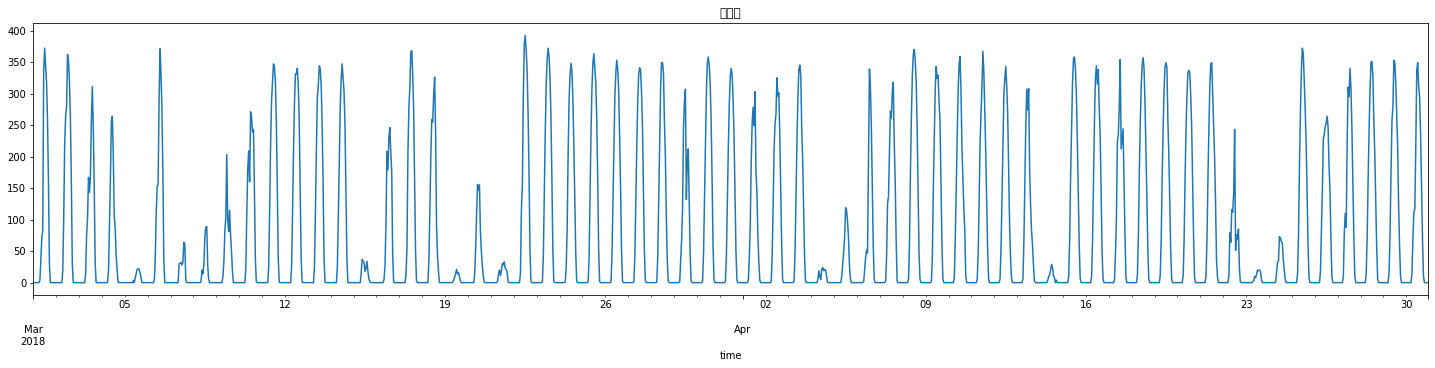

In [ ]:
#발전량 시각화
ulsan['y'][:'2018-04'].plot(title = '발전량', figsize=(25,5)) #3개월정도

In [ ]:
ulsan.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25632 entries, 2018-03-01 00:00:00 to 2021-01-31 23:00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temp           25632 non-null  float64
 1   windSpeed      25632 non-null  float64
 2   windDirection  25632 non-null  float64
 3   humidity       25632 non-null  float64
 4   cloud          24807 non-null  float64
 5   sun_hr         25632 non-null  float64
 6   solar          25632 non-null  float64
 7   year           25632 non-null  int64  
 8   month          25632 non-null  int64  
 9   day            25632 non-null  int64  
 10  hour           25632 non-null  int64  
 11  season         25632 non-null  int64  
 12  y              25632 non-null  int64  
dtypes: float64(7), int64(6)
memory usage: 4.0 MB


In [ ]:
ulsan_df=ulsan[['y']]
ulsan_df

,y
time,
2018-03-01 00:00:00,0
2018-03-01 01:00:00,0
2018-03-01 02:00:00,0
2018-03-01 03:00:00,0
2018-03-01 04:00:00,0
...,...
2021-01-31 19:00:00,0
2021-01-31 20:00:00,0
2021-01-31 21:00:00,0


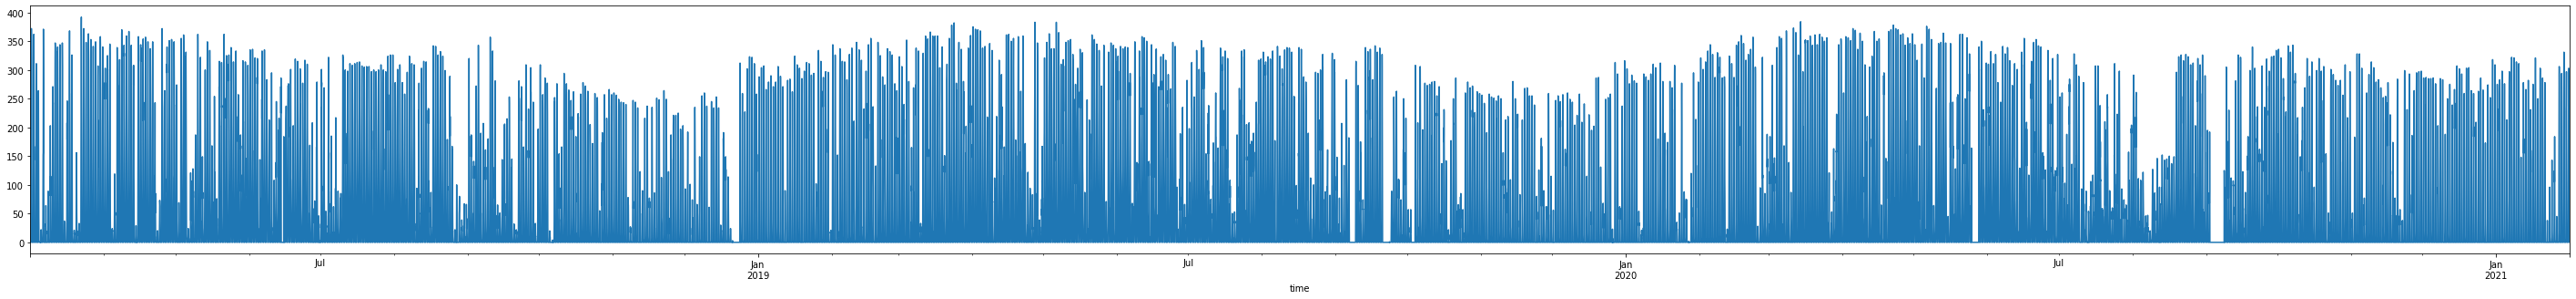

In [ ]:
ulsan_df['y'].plot(figsize=(50,5))

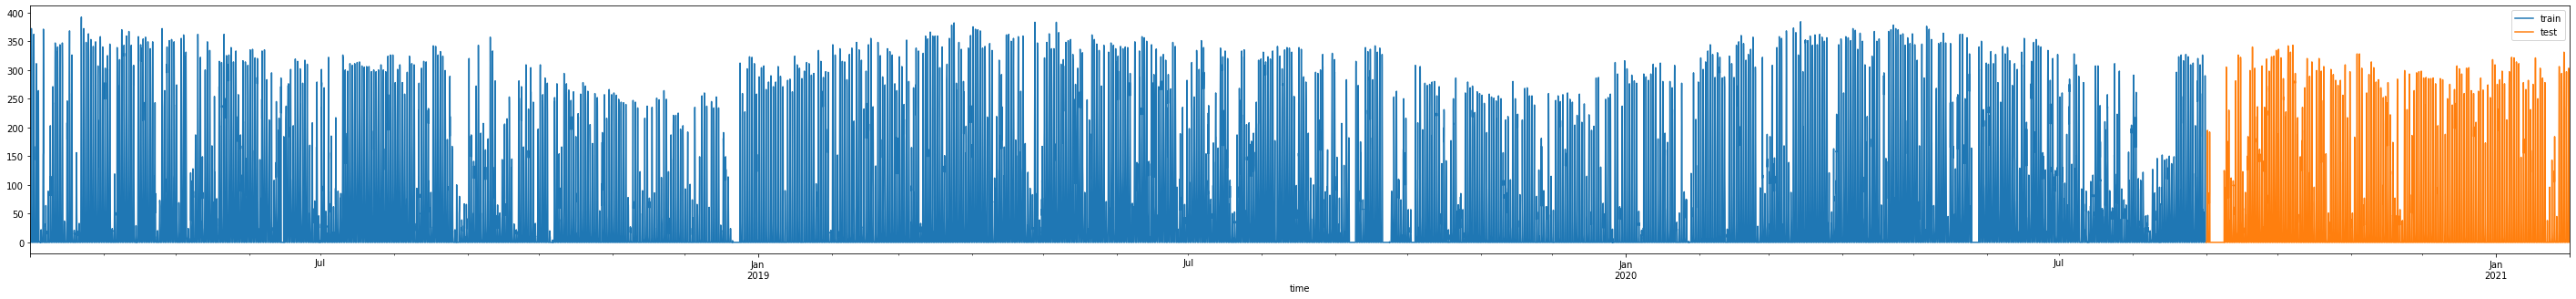

In [ ]:
# 2020년 9월까지의 데이터를 트레이닝셋.
# 그 이후 데이터를 테스트셋으로 한다.
split_date = pd.Timestamp('2020-09-01')


train = ulsan_df.loc[:split_date, ['y']]
test = ulsan_df.loc[split_date:, ['y']]

ax = train.plot(figsize=(50,5))
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [ ]:
#1. 훈련 데이터의 분포 추정 : 훈련 데이터를 입력으로 하여 fit 메서드를 실행하여 분포 모수를 객체내에 저장
#2. 훈련 데이터의 변환 : 훈련 데이터를 입력으로 하여 transform 메서드를 실행하면 훈련 데이터를 변환
#3. 테스트 데이터의 변환: 테스트 데이터를 입력으로 하여 transform 메서드를 실행하여 테스트 데이터를 변환.

#훈련 데이터는 1번과 2번 과정을 합쳐서 fit_transform 메서드를 사용하고 테스트 데이터는 transform 메서드를 사용하여 스케일링을 진행

from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

train_sc

#데이터프레임으로 변환
train_sc_df = pd.DataFrame(train_sc, columns=['energy'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['energy'], index=test.index)
test_sc_df

,energy
time,
2020-09-01 00:00:00,0.0
2020-09-01 01:00:00,0.0
2020-09-01 02:00:00,0.0
2020-09-01 03:00:00,0.0
2020-09-01 04:00:00,0.0
...,...
2021-01-31 19:00:00,0.0
2021-01-31 20:00:00,0.0
2021-01-31 21:00:00,0.0


### sliding window 구성하기
window는 LSTM을 훈련하기 위한 단위로 고정된 사이즈를 가짐.  
window가 12개라면 과거 시간 데이터 12개를 사용해서 다음 시간 단위의 값을 예측  
과거의 시간 단위 12개 발전량이 훈련 속성들이 되고 현재 시간의 발전량이 target

sliding window 타입의 데이터를 구성하려면 dataframe의 shift 연산을 사용  
-> 인덱스는 그대로 두고 데이터만 시간 단위로 이동 가능  
ex) shift(1)을 하면 바로 다음 시간 인덱스로 데이터가 이동하며 shift(-1)을 하면 바로 이전 시간 인덱스로 데이터가 이동

In [ ]:
for s in range(1, 13):
    train_sc_df[f'shift_{s}'] = train_sc_df['energy'].shift(s)
    test_sc_df[f'shift_{s}'] = test_sc_df['energy'].shift(s)

train_sc_df

,energy,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
time,,,,,,,,,,,,,
2018-03-01 00:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,0.0,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31 20:00:00,0.0,0.0,0.010204,0.112245,0.331633,0.553571,0.739796,0.517857,0.303571,0.181122,0.089286,0.058673,0.132653
2020-08-31 21:00:00,0.0,0.0,0.000000,0.010204,0.112245,0.331633,0.553571,0.739796,0.517857,0.303571,0.181122,0.089286,0.058673
2020-08-31 22:00:00,0.0,0.0,0.000000,0.000000,0.010204,0.112245,0.331633,0.553571,0.739796,0.517857,0.303571,0.181122,0.089286


#### shift 사용하여 window 구성
shift(1)을 사용한 칼럼은 데이터 값이 다음 시간 인덱스로 한칸씩 이동  
dropna로 NaN값을 포함한 데이터를 제거  
shift_1 ~ shift_12는 X로 energy는 Y로 지정

In [ ]:
X_train = train_sc_df.dropna().drop('energy', axis=1)
y_train = train_sc_df.dropna()[['energy']]

X_test = test_sc_df.dropna().drop('energy', axis=1)
y_test = test_sc_df.dropna()[['energy']]

#### 다시 ndarray로 변환하기

실제 deep learning 모델의 트레이닝과 테스트로 사용되는 데이터는 일반적으로 numpy의 ndarray.  
.values를 통해 ndarray 값을 얻기  
트레이닝 데이터는 timestep=12, size = 21949

In [ ]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values
print(X_train.shape)
print(X_train)
print(y_train.shape)
print(y_train)

(21949, 12)
[[0.85204082 0.20918367 0.18112245 ... 0.         0.         0.        ]
 [0.94897959 0.85204082 0.20918367 ... 0.         0.         0.        ]
 [0.88265306 0.94897959 0.85204082 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.30357143 0.18112245 0.08928571]
 [0.         0.         0.         ... 0.51785714 0.30357143 0.18112245]
 [0.         0.         0.         ... 0.73979592 0.51785714 0.30357143]]
(21949, 1)
[[0.94897959]
 [0.88265306]
 [0.81122449]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]


### 최종 트레이닝셋과 테스트셋의 X 만들기

이부분이 중요!  
keras에서는 RNN 계열의 모델을 트레이닝할 때 요구하는 데이터의 형식이 있음  
- 3차원 데이터여야하며 
- 각각의 차원은 (size, timestep, feature) 을 순서대로 나타내야함  
- 이 형태로 데이터를 reshape 해주어야함 
일반적인 MLP 모델에서는 size와 feature만 있기 때문에 2차원이지만, RNN에서는 "시간" 이라는 개념이 있기 때문에 차원이 한 차원 늘어남  

In [ ]:
#Training set과 Test set의 X를 RNN 학습에 맞는 형태로 reshape

X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)

print("최종 DATA")
print(X_train_t.shape)
print(X_train_t)
print(y_train)

최종 DATA
(21949, 12, 1)
[[[0.85204082]
  [0.20918367]
  [0.18112245]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.94897959]
  [0.85204082]
  [0.20918367]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.88265306]
  [0.94897959]
  [0.85204082]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 ...

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.30357143]
  [0.18112245]
  [0.08928571]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.51785714]
  [0.30357143]
  [0.18112245]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.73979592]
  [0.51785714]
  [0.30357143]]]
[[0.94897959]
 [0.88265306]
 [0.81122449]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]


### LSTM 모델 만들기

- input_shape=(timestep, feature)  
- size는 모델 설계시에는 중요하지 않으므로, feature, timestep만 모델에 알려주면 된다  
- 예측하고자하는 target의 갯수가 1이므로 마지막에 Dense(1)을 하나 추가  
- 실제 연속적인 값을 예측하는 것이기 때문에 loss function은 mean squared error
- 일반적으로 optimizer는 adam을 자주 사용

In [ ]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping 

K.clear_session() 
model = Sequential() # Sequeatial Model 
model.add(LSTM(20, input_shape=(12, 1))) # (timestep, feature) 
model.add(Dense(1)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


#### 모델 Fitting

- Training data set으로 optimization 과정을 통해 모델의 weight를 찾는 것
- early stopping 객체를 이용해 epoch마다 early stopping을 체크

In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X_train_t, y_train, epochs=100,
          batch_size=30, verbose=1, callbacks=[early_stop])

Epoch 1/100
732/732 [==============================] - 7s 6ms/step - loss: 0.0317
Epoch 2/100
732/732 [==============================] - 4s 6ms/step - loss: 0.0071
Epoch 3/100
732/732 [==============================] - 4s 6ms/step - loss: 0.0063
Epoch 4/100
732/732 [==============================] - 4s 6ms/step - loss: 0.0060
Epoch 5/100
732/732 [==============================] - 4s 6ms/step - loss: 0.0053
Epoch 6/100
732/732 [==============================] - 4s 6ms/step - loss: 0.0055
Epoch 00006: early stopping


#### 학습된 모델을 통해 테스트셋 Test 하기

테스트셋은 2020-09-01 이후의 데이터,
트레이닝에는 그 전 데이터를 넣어줌

In [ ]:
print("테스트셋의 모양")
#트레이닝셋과 구조 같음
print(X_test_t)


#model.predict를 통해 테스트셋의 X에 대한 예측값 y_hat을 얻기

y_pred = model.predict(X_test_t)
print(y_pred)

테스트셋의 모양
[[[0.29081633]
  [0.4005102 ]
  [0.11479592]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.17346939]
  [0.29081633]
  [0.4005102 ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.32653061]
  [0.17346939]
  [0.29081633]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 ...

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.7244898 ]
  [0.60714286]
  [0.39795918]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.77295918]
  [0.7244898 ]
  [0.60714286]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.75      ]
  [0.77295918]
  [0.7244898 ]]]
[[0.51881826]
 [0.29441655]
 [0.31976718]
 ...
 [0.01771977]
 [0.0174887 ]
 [0.01524941]]


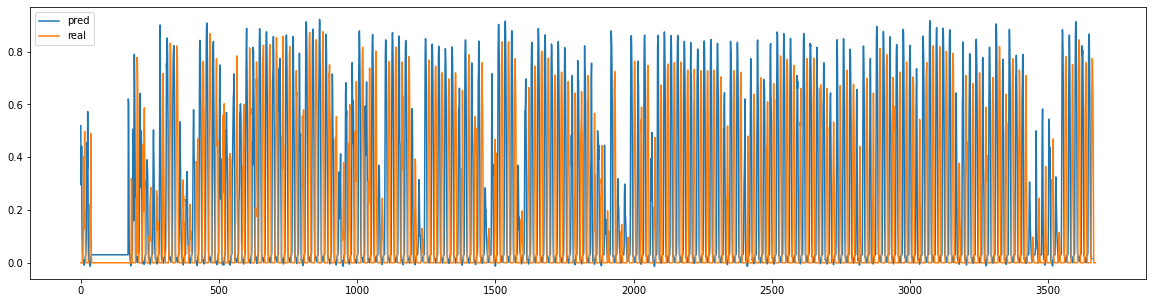

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(y_pred)
plt.plot(test_sc)
plt.legend(['pred','real'])

In [2]:
#2021년 2월달 넣어보기


#model.predict()
X_test_t

NameError: ignored

출처: https://3months.tistory.com/168 [Deep Play]

In [ ]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# result = seasonal_decompose(ulsan_df, model='multiplicative')
# result.plot()
# plt.show()
# #시계열 망가지면 안됨.

## ARIMA 모델
- ARIMA의 모수 
  - AR모형의 Lag을 의미하는 p 
  - MA모형의 Lag을 의미하는 q
  - 차분(Diffrence)횟수를 의미하는 d
보통은 p, d, q의 순서로 쓴다.  
통상적으로 $p + q < 2$, $p * q = 0$ 인 값들을 많이 사용한다.

- ACF(Autocorrelation function) : Lag에 따른 관측치들 사이의 관련성을 측정하는 함수  (k 시간 단위로 구분된 시계열의 관측치(yt 및 yt–k) 간 상관의 측도)
eq_acf  
- PACF(Partial autocorrelation function) : k 이외의 모든 다른 시점 관측치의 영향력을 배제하고eq_yt와 eq_ytk 두 관측치의 관련성을 측정하는 함수
eq_pacf  
시계열 데이터가 AR의 특성을 띄는 경우, ACF는 천천히 감소하고 PACF는 처음 시차를 제외하고 급격히 감소한다. ARMA(0,1)  
반대로, MA의 특성을 띄는 경우 ACF는 급격히 감소하고 PACF는 천천히 감소한다. ARMA(1,0)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ulsan_df)
plot_pacf(ulsan_df)
plt.show()

- 자기상관함수(ACF)
  - ACF를 보면 12시간 단위로 자기상관이 양과 음 사이에서 변동한다.  
  - 시차 1에서의 큰 값 뒤에 양의 상관과 음의 상관 사이를 교대로 움직이는 감소파가 나옴. 
  -> 데이터에 고차 자기 회귀 항이 있음

- 편 자기상관함수(PACF)
  - PACF는 1의 Time lag에서 약 0.9를 보이고 이후에 급격히 감소한다. 
  - 유의한 큰 값이 있으므로 상관이 0이 아니다. 

- 따라서 p=0, q=1..이 적당하다고 추측? 

울산데이터는 정상적이지 않은 시계열 데이터
non-stationary 이므로 차분해야함

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

#(AR(Autoregression)=2, 차분=1, MA(이동평균)=2)로 학습
model=ARIMA(ulsan.y.values, order=(2,1,2))
model_fit=model.fit(trend='c', full_output=True, disp=True)

In [ ]:
model_fit.summary() #상수가 안좋다.

In [ ]:
#모델 성능 및 시각화 (2,1,2)
fig=model_fit.plot_predict() #학습 데이터에 대한 예측 결과
residuals=pd.DataFrame(model_fit.resid) #잔차 변동 시각화
residuals.plot()

In [ ]:
#(p,d,q)=(0,1,1)
fig=model_fit.plot_predict() #학습 데이터에 대한 예측 결과
residuals=pd.DataFrame(model_fit.resid) #잔차 변동 시각화
residuals.plot()

In [ ]:
forecast_data=model_fit.forecast(steps=10)#10일 뒤 예측

#테스트 데이터셋 가져오기
#ulsan_df=ulsan[['y']].reset_index()

In [ ]:
pred_y=forecast_data[0].tolist() #마지막 10일의 예측 데이터 (2021-01-20~2021-01-31)
test_y=ulsan_df.y.values #실제 10일 데이터
pred_y_min=[] #10일짜리 예측 데이터의 최소값
pred_y_max=[] #10일짜리 예측 데이터의 최대값
for lower_upper in forecast_data[2]:
  lower=lower_upper[0]
  upper=lower_upper[1]
  pred_y_min.append(lower)
  pred_y_max.append(upper)

In [ ]:
plt.plot(pred_y[:500], color='gold') #모델이 예상한 그래프
#plt.plot(pred_y_min, color='red') #모델이 예상한 최소 그래프
#plt.plot(pred_y_max, color='blue') #모델이 예상한 최대 그래프
plt.plot(test_y[:500]) #실제 그래프

In [ ]:
#RMSE 점수


In [ ]:
#답
submission

### 시계열로 cloud 열 채우기
- 결측치 전까지의 데이터로 결측치 하루씩 예측 
- 데이터 전처리 : ???

In [ ]:
ulsan_cloud=ulsan[['cloud']]
ulsan_cloud[ulsan_cloud['cloud'].isnull()].index

In [ ]:
#결측치가 있으면 값이 안나온다
plot_acf(ulsan_cloud)
plot_pacf(ulsan_cloud)
plt.show()

## Facebook Prophet
- fbprophet 패키지 설치 필요
- input data columns 는 'ds' 와 'y'로 고정
- seasonality_mode: 연간, 월간, 주간, 일간 등 트렌드성을 반영하는 것 의미.
- changepoint_prior_scale: 트렌드가 변경되는 문맥을 반영하여 예측. 수치가 높을수록 과적합

In [ ]:
from fbprophet import Prophet

In [ ]:
#데이터의 피처 이름을 'ds'와 'y'로 변경
ulsan_df_prophet=ulsan.reset_index().rename(columns={'time':'ds'})[['ds','y']]

prophet=Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=True,
                changepoint_prior_scale=0.5)
prophet.fit(ulsan_df_prophet)

In [ ]:
#모델에 예측 기간 넣고 결과 도출
future_data=prophet.make_future_dataframe(periods=10, freq='h')
forecast_dt=prophet.predict(future_data)

In [ ]:
forecast_dt.tail(10)

In [ ]:
#결과 도출
def sola_nmae(answer_df, submission_df):
    submission = submission_df[submission_df['time'].isin(answer_df['time'])]
    submission.index = range(submission.shape[0])
    
    # 시간대별 총 발전량
    sum_submission = submission.iloc[:,1:].sum(axis=1)
    sum_answer = answer_df.iloc[:,1:].sum(axis=1)
    
    # 발전소 발전용량
    capacity = {
        'dangjin_floating':1000, # 당진수상태양광 발전용량
        'dangjin_warehouse':700, # 당진자재창고태양광 발전용량
        'dangjin':1000, # 당진태양광 발전용량
        'ulsan':500 # 울산태양광 발전용량
    }
    
    # 총 발전용량
    total_capacity = np.sum(list(capacity.values()))
    
    # 총 발전용량 절대오차
    absolute_error = (sum_answer - sum_submission).abs()
    
    # 발전용량으로 정규화
    absolute_error /= total_capacity
    
    # 총 발전용량의 10% 이상 발전한 데이터 인덱스 추출
    target_idx = sum_answer[sum_answer>=total_capacity*0.1].index
    
    # NMAE(%)
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae